In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc, DIRECT_ACC_MATRIX
from jdgsim.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass, E_tot, Angular_momentum
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits
from jdgsim.visualization import create_3d_gif,create_3d_gif_velocitycoding, create_projection_gif


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=10, 
                          external_accelerations=(), 
                          acceleration_scheme=DIRECT_ACC_MATRIX,
                          softening=1e-10) #default values

params = SimulationParams(t_end = (0.5 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=10, softening=1e-10, integrator=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=())
SimulationParams(G=1, t_end=np.float64(0.3353543704601728), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28))


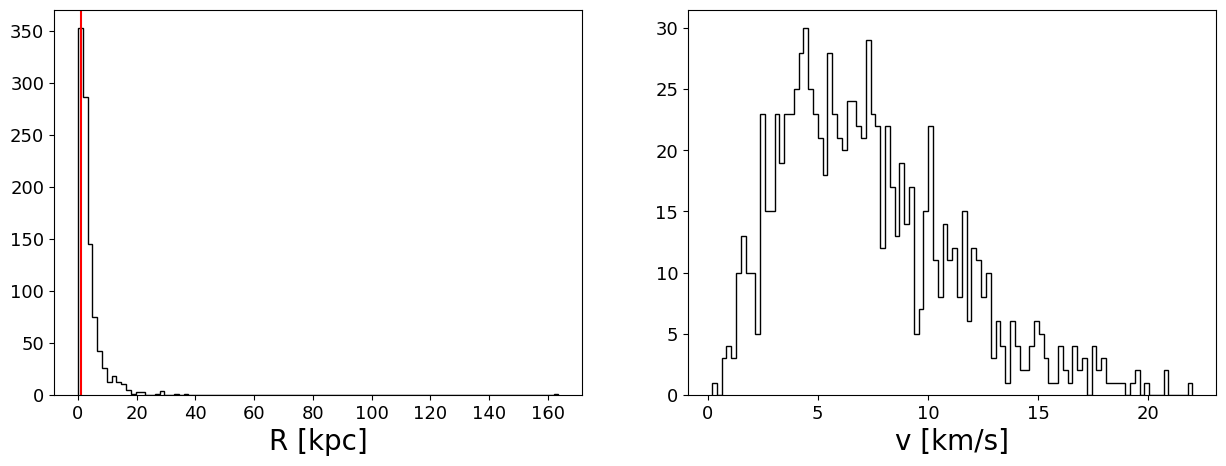

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


#initialize the initial state
target_state = construct_initial_state(positions, velocities)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]


In [5]:
target_state = time_integration(target_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]

def time_integration_for_mass_grad(Mtot, ):
    params = SimulationParams(t_end = (0.1 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=Mtot,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, )  
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
    initial_state = construct_initial_state(positions, velocities)
    
    final_state = time_integration(initial_state, mass, config, params)
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    # loss = (((energy - energy_target)/energy_target)**2) + (Lz - Lz_target)**2
    loss = ((Lz - Lz_target)/Lz_target)**2 
    return loss 


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = (0.99*1e8 * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(Mtot, )
# loss = time_integration_for_mass_grad(Mtot, )
print("Gradient of the total mass of the Plummer sphere:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Plummer sphere:
 -0.005037815259213278
Loss:
 2.512578676010246e-05


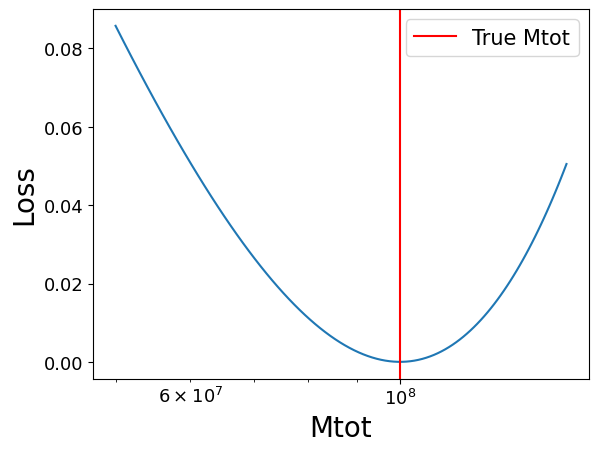

In [6]:
Mtot =  (jnp.linspace(0.5*1e8, 1.5*1e8, 100) * u.Msun).to(code_units.code_mass).value
loss = vmap(time_integration_for_mass_grad)(Mtot)

plt.figure()
plt.plot((Mtot*code_units.code_mass).to(u.Msun), loss)
plt.axvline((1e8 * u.Msun).value, color='r', label='True Mtot')
plt.xlabel('Mtot')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()


In [7]:
target_state = time_integration(target_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]

def time_integration_for_mass_grad(t_end, ):
    params = SimulationParams(t_end = t_end,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, )  
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
    initial_state = construct_initial_state(positions, velocities)
    
    final_state = time_integration(initial_state, mass, config, params)
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    loss = ((energy - energy_target)/energy_target)**2  + ((Lz - Lz_target)/Lz_target)**2
    # loss = ((Lz - Lz_target)/Lz_target)**2 
    # loss = ((energy - energy_target)/energy_target)**2
    
    return loss 


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = (0.1 * u.Gyr).to(code_units.code_time).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(t_end, )
# loss = time_integration_for_mass_grad(Mtot, )
print("Gradient of the total mass of the Plummer sphere:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Plummer sphere:
 -454954356.44463027
Loss:
 2722059.5286928574


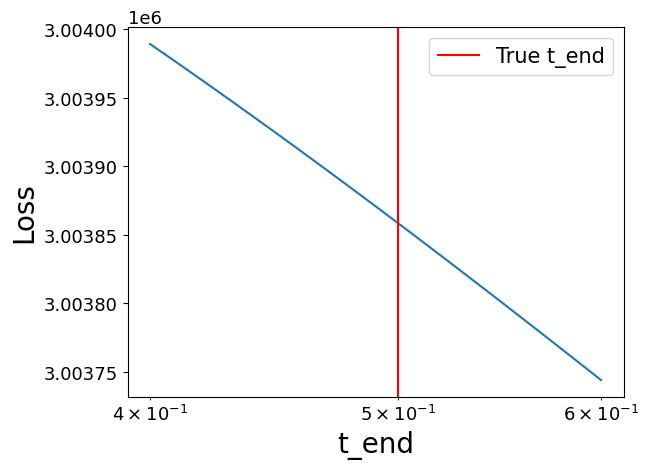

In [8]:
t_end =  (jnp.linspace(0.4, 0.6, 100) * u.Myr).to(code_units.code_time).value
loss = vmap(time_integration_for_mass_grad)(t_end)

plt.figure()
plt.plot((t_end*code_units.code_time).to(u.Myr), loss)
plt.axvline((0.5 * u.Myr).value, color='r', label='True t_end')
plt.xlabel('t_end')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()


In [9]:
target_state = time_integration(target_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]

def time_integration_for_mass_grad(M_tot, t_end, ):
    params = SimulationParams(t_end = t_end,  
                          Plummer_params= PlummerParams(Mtot=M_tot,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, )  
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
    initial_state = construct_initial_state(positions, velocities)
    
    final_state = time_integration(initial_state, mass, config, params)
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    # loss = ((energy - energy_target)/energy_target)**2  + ((Lz - Lz_target)/Lz_target)**2
    loss = ((Lz - Lz_target)/Lz_target)**2 
    # loss = ((energy - energy_target)/energy_target)**2
    return loss 


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = (0.1 * u.Gyr).to(code_units.code_time).value
M_tot = (0.99*1e8 * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(M_tot, t_end,)
# loss = time_integration_for_mass_grad(Mtot, )
print("Gradient of the total mass of the Plummer sphere:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Plummer sphere:
 -0.005037815259213066
Loss:
 2.5125786760100076e-05


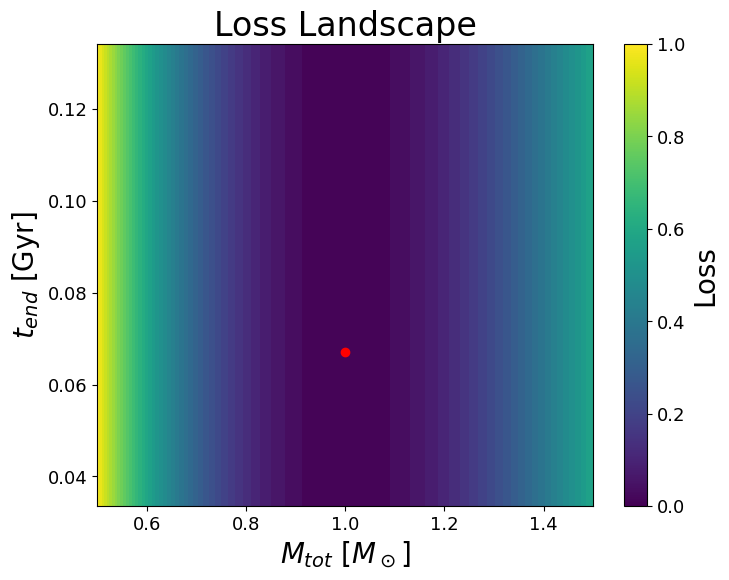

In [10]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

# Define the range of M_tot and t_end values
M_tot_values = (jnp.linspace(0.5e8, 1.5e8, 50)*u.Msun).to(code_units.code_mass).value  # Adjust range based on expected values
t_end_values = (jnp.linspace(0.05, 0.2, 50)*u.Gyr).to(code_units.code_time).value     # Adjust range based on expected timescales

# Create a meshgrid
M_tot_grid, t_end_grid = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Vectorize the loss function over a single input (M_tot, t_end)
batched_loss_fn = jax.vmap(time_integration_for_mass_grad, in_axes=(0, 0))

# Flatten the grid for batch processing
M_tot_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()

# Compute losses in parallel
loss_values_flat = batched_loss_fn(M_tot_flat, t_end_flat)

# Reshape back to grid
loss_values = loss_values_flat.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values, t_end_values, loss_values.T, levels=50, cmap="viridis")
plt.scatter((1e8 * u.Msun).to(code_units.code_mass).value, (0.1 * u.Gyr).to(code_units.code_time).value, color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$M_{tot}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("Loss Landscape")
plt.show()
